# Assignment 3: Text Classification and Word Embeddings

Due: Monday, January 23, 2023, at 2pm via Moodle

**Team Members** `
Yanxin Jia, 3769165
Shreyansu Vyas, 3769429
Smaran Nair , 3771609
AnuReddy , 3768482`

### Submission Guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will see that this notebook contains some pre-filled cells that you should complete for the individual tasks.
- For answers requiring written solutions, use Markdown cells (in combination with Jupyter LaTeX support) **inside this notebook**. Do *not* hand in any separate files, simply re-upload the `.ipynb` file.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- Make sure that the names of all team members are present in the solution (see cell above).

In [1]:
%%python "--version"
# check requirements


Python 3.10.8


In [2]:
# Install necessary packages
%pip install "-r" requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [3]:
%%python "-m" spacy download en_core_web_sm
# Install required language model for spaCy

     --------------------------------------- 12.8/12.8 MB 12.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Task 1: F.R.I.E.N.D.S and  Word2Vec (6 + 8 + 4 = 18 Points)

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this problem set we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

In [4]:
import re  
import pandas as pd  
from collections import defaultdict, Counter  
import spacy 
import logging
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
import sys
from sklearn.manifold import TSNE
from typing import Type
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Pre-processing (6 Points)

We start by loading and cleaning the data. The dataset for this problem set can be found in the attached `data` folder. Load the `friends_quotes.csv` file using pandas. The dataset is from [Kaggle](https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that can determine which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains the line from the movie and `author` is the one who spoke it. Since these are the only two columns we need, we remove the rest and only keep these two. 

In [5]:
# setting up logging to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= "%H:%M:%S", level=logging.INFO)

In [6]:
df = pd.read_csv("./data/friends_quotes.csv")
### filter out columns ###
df.head(10)

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
5,Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax. This is not even a date...",5.0,1.0
6,Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
7,Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back in high school, I'm stand...",7.0,1.0
8,All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
9,Chandler,1.0,Monica Gets A Roommate,"Then I look down, and I realize there's a phon...",9.0,1.0


Fortunately, there is no missing data, so we do not need to worry about that. 

In [7]:
df.isnull().sum() # check for missing data

author            0
episode_number    0
episode_title     0
quote             0
quote_order       0
season            0
dtype: int64

Use SpaCy similar to assignment 2 to pre-process the text and perform the following steps: 
- lowercase the words 
- remove stopwords and single characters
- use regex to remove non-alphabetic characters; in other words: only keep "a" to "z" and digits. 
- remove lines that have less than 3 words, since they cannot contribute much to the training process.

Please do not add additional steps on your own or additional cleaning as we want to create comparable results. 

In [8]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "lemmatizer"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS # only use these stop words, do not add your own!
df["quote"] = df["quote"].str.casefold()
df["quote"] = df["quote"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df["quote"] = df["quote"].str.replace('[^a-zA-Z0-9]', ' ', regex=True).str.strip()
df["quote"] = df["quote"].str.replace('\\b\\w{1,2}\\s', ' ', regex=True).str.strip()
df = df[df["quote"].str.split().str.len().gt(3)]


C'mon, you're going out with the guy! There's gotta be something wrong with him!
c'mon, you're going out with the guy! there's gotta be something wrong with him!
c'mon, you're going guy! there's gotta wrong him!
c mon  you re going guy  there s gotta wrong him


In [9]:
df["quote"].head(10)

0                          there  tell    guy work with
1           mon  you  going guy  there  gotta wrong him
2                right joey  nice  hump  hump hairpiece
4                 just   cause  don  want went carl  oh
5     okay  everybody relax  date    people going di...
6                                   sounds like date me
7     alright    high school    standing middle cafe...
9              look down  realize there  phone    there
14    sudden  phone starts ring  don  know   everybo...
16    finally  figure   better answer   turns   moth...
Name: quote, dtype: object

In [10]:
quotes =df["quote"].tolist() # to save all the lines

In [11]:
quotes_temp_list = []
for item in quotes:
    lst_temp = item.split(" ")
    lst_temp = [x.strip() for x in lst_temp if x.strip()]
    quotes_temp_list.append(lst_temp)
quotes = quotes_temp_list

In [ ]:
print(quotes[:10])
# preserve the original version of quotes


[['there', 'tell', 'guy', 'work', 'with'], ['mon', 'you', 'going', 'guy', 'there', 'gotta', 'wrong', 'him'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['just', 'cause', 'don', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'and', 'having', 'sex'], ['sounds', 'like', 'date', 'me'], ['alright', 'high', 'school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked'], ['look', 'down', 'realize', 'there', 'phone', 'there'], ['sudden', 'phone', 'starts', 'ring', 'don', 'know', 'everybody', 'starts', 'looking', 'me'], ['finally', 'figure', 'better', 'answer', 'turns', 'mother', 'very', 'very', 'weird', 'because', 'calls', 'me']]


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, to keep the computation time-limited.

In [13]:
words =  Phrases(quotes, min_count=10) 
bigram =  Phraser(words)
#new_lines = # transform the lines #
#new_lines[0]

INFO - 09:33:09: collecting all words and their counts
INFO - 09:33:09: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 09:33:09: PROGRESS: at sentence #10000, processed 86118 words and 64214 word types
INFO - 09:33:09: PROGRESS: at sentence #20000, processed 174387 words and 111649 word types
INFO - 09:33:10: PROGRESS: at sentence #30000, processed 261704 words and 155469 word types
INFO - 09:33:10: collected 170125 token types (unigram + bigrams) from a corpus of 291447 words and 33546 sentences
INFO - 09:33:10: merged Phrases<170125 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 09:33:10: Phrases lifecycle event {'msg': 'built Phrases<170125 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.48s', 'datetime': '2023-01-23T09:33:10.097525', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
INFO - 09:33:10:

In [14]:
new_lines =  bigram[quotes]
new_lines[5]
# shows that it detects phrases

['sounds_like', 'date', 'me']

In [15]:
### find the top words for the vocabulary###
top_words = Counter(word for new_lines in new_lines for word in new_lines)
vocab = sorted(top_words.items(), key=lambda x: x[1], reverse=True)[:15000] 
vocab[:5]### top words ###

[('know', 6302), ('you', 5857), ('okay', 3784), ('don', 3602), ('that', 3602)]

In [16]:
vocab[-1]

('squints', 1)

In [ ]:
# train only for the top words
vocab_lst = [x[0] for x in vocab]
lines = [] # to store the new lines
for i in range(len(new_lines)):
    element = new_lines[i]
    lines.append([x for x in element if x in vocab_lst])

In [ ]:
print(lines[:5])

[['there', 'tell', 'guy', 'work', 'with'], ['mon', 'you', 'going', 'guy', 'there', 'gotta', 'wrong', 'him'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['just', 'cause', 'don', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'and', 'having_sex']]


### 2. Training (8 Points)

Use the Gensim implementation of Word2Vec to train a model on the quotes. The training can be divided into 3 stages:

1. Set up and configure your model. Define the parameters in such a way that the following conditions are satisfied:
    - Ignores all words that have a total absolute frequency less than 2
    - Dimensions of the embeddings: 100 
    - Initial learning rate of 0.03 
    - 20 negative samples 
    - Window size 3 
    - The learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
    - Set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
    - Set the hashfunction of the word2vec to the given function.
    - Train on a single worker to make sure you get the same result as ours.

In [20]:
def hash(astring):
    return ord(astring[0])

In [21]:
w2v = Word2Vec(min_count = 2, vector_size = 100, alpha = 0.03, \
    negative = 20, window = 3, min_alpha = 0.0001, sample = 6e-5, \
        hashfxn = hash,  workers = 1)

INFO - 09:33:27: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2023-01-23T09:33:27.158691', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [ ]:
training_data = lines # lines

2. Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus. Use the `build_vocab` function to process the data.

In [23]:
w2v.build_vocab(corpus_iterable=training_data)
# w2v.build_vocab(corpus_iterable=new_lines)

INFO - 09:33:27: collecting all words and their counts
INFO - 09:33:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:33:27: PROGRESS: at sentence #10000, processed 83852 words, keeping 9048 word types
INFO - 09:33:27: PROGRESS: at sentence #20000, processed 169452 words, keeping 12091 word types
INFO - 09:33:27: PROGRESS: at sentence #30000, processed 254065 words, keeping 14738 word types
INFO - 09:33:27: collected 15000 word types from a corpus of 282408 raw words and 33546 sentences
INFO - 09:33:27: Creating a fresh vocabulary
INFO - 09:33:27: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9158 unique words (61.05% of original 15000, drops 5842)', 'datetime': '2023-01-23T09:33:27.411410', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
INFO - 09:33:27: Word2Vec lifecycle event {'msg': 'effective_min_count=

3. Finally, we get to train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis. 

In [ ]:
w2v.train(training_data, total_examples=w2v.corpus_count, epochs = 100)

INFO - 09:33:27: Word2Vec lifecycle event {'msg': 'training model with 1 workers on 9158 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2023-01-23T09:33:27.609507', 'gensim': '4.3.0', 'python': '3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
INFO - 09:33:28: EPOCH 0: training on 282408 raw words (127416 effective words) took 0.5s, 244392 effective words/s
INFO - 09:33:28: EPOCH 1: training on 282408 raw words (127649 effective words) took 0.5s, 247177 effective words/s
INFO - 09:33:29: EPOCH 2: training on 282408 raw words (128004 effective words) took 0.6s, 218675 effective words/s
INFO - 09:33:29: EPOCH 3: training on 282408 raw words (128016 effective words) took 0.5s, 240347 effective words/s
INFO - 09:33:30: EPOCH 4: training on 282408 raw words (127579 effective words) took 0.5s, 253715 effective words/s
INFO - 09:33:30:

(12780762, 28240800)

In [25]:
w2v.init_sims()
# NOTE:according to documentation, fill_norms() is perferred for the
# same purpose.

C:\Users\shrey\AppData\Local\Temp\ipykernel_13376\3544636113.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims()


### 3. Exploration (4 Points)

As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset: 

We look for the most similar words to the famous coffee shop where most of the episodes took place, namely `central_perk` and also for the ones similar to the character `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.

In [26]:
w2v.wv.most_similar('joey', topn=10)

[('chandler', 0.8284000158309937),
 ('monica', 0.7637611031532288),
 ('ross', 0.7636315226554871),
 ('rachel', 0.7479551434516907),
 ('phoebe', 0.7027038931846619),
 ('him', 0.6914896368980408),
 ('she', 0.6334748864173889),
 ('her', 0.6288197040557861),
 ('hey', 0.6271514892578125),
 ('again', 0.6186447739601135)]

In [27]:
w2v.wv.most_similar('central_perk', topn=10)

[('conan', 0.5805825591087341),
 ('sitting_couch', 0.5189305543899536),
 ('laying', 0.4634341895580292),
 ('hippity', 0.44827377796173096),
 ('mitzi', 0.4366980493068695),
 ('bonnie', 0.42854806780815125),
 ('village', 0.40935271978378296),
 ('russ', 0.40771058201789856),
 ('recliner', 0.4046947658061981),
 ('cheryl', 0.4007519781589508)]

Look at the similarity of `mrs_green` to `rachel` (her mom) and `ross`  to `spaceship` (unrelated). The first one should have a high score whereas the second should have a low score. Finally look at the similarity of `smelly_cat` (a song from pheobe) and `song`, which should have a high value.

In [28]:
w2v.wv.similarity("mrs_green", "rachel")

0.3978841

In [29]:
w2v.wv.similarity("ross", "spaceship")

-0.21716724

In [30]:
w2v.wv.similarity("song", "smelly_cat")

0.49687085

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar? 

In [31]:
character_names= ["joey", "rachel", "phoebe", "monica", "chandler"]
w2v.wv.doesnt_match(character_names)

'phoebe'

Based on analogies: Which word is to `rachel` as `man` is to `women`? (print the top 3); you should get `chandler` and `monica` among the answers.

In [32]:
w2v.wv.most_similar(positive = ["man", "rachel"], negative = ["women"], topn=3)

[('chandler', 0.6586422920227051),
 ('joey', 0.6485732197761536),
 ('monica', 0.6336694359779358)]

In [33]:
w2v.wv.most_similar_cosmul(positive = ["man", "rachel"], negative = ["women"], topn=3)

[('chandler', 1.1777974367141724),
 ('joey', 1.155563235282898),
 ('monica', 1.1253297328948975)]

Finally, let's use t-SNE to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [34]:
def tsneplot(model: Type[Word2Vec], word: str):
    """ 
    Uses seaborn to plot the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimiliar words. 
    """
    embs = np.empty((1,100), dtype="f")    # to save all the embeddings
    word_labels = [word]
    color_list  = ["green"]

    # print(model.wv.get_vector(word, norm = True).shape)
    embs = np.append(embs,np.array(model.wv.get_vector(word, norm = True)).reshape(1,100),axis = 0) # adds the vector of the query word
    # print(embs.shape)
    close_words = model.wv.most_similar(word, topn = 10) # gets list of most similar words
    all_sims = model.wv.similar_by_word(word) 
    far_words = all_sims[-10:]     # gets list of most dissimilar words (get the sorted list of all the words and their similarity and choose the bottom 10)


    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.get_vector(wrd_score[0], norm = True)
        word_labels.append(wrd_score[0])
        color_list.append("blue")
        embs = np.append(embs, np.array(wrd_vector).reshape(1,100), axis=0)
        
    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.get_vector(wrd_score[0], norm = True)
        word_labels.append(wrd_score[0])
        color_list.append("red")
        embs = np.append(embs,np.array(wrd_vector).reshape(1,100), axis=0)
    # print(embs.shape)
    np.set_printoptions(suppress=True)
    Y = TSNE(learning_rate=200, \
        random_state=42, perplexity=15, init="random").fit_transform(embs)
    print(Y)
    # NOTE: n_components = 2 is default value
    # with  n_components=2, learning_rate=200, random_state=42, perplexity=15, init="random"
    # sets everything up to plot

    df = pd.DataFrame.from_dict({"x": [x[0] for x in Y],
                                "y": [y[1] for y in Y],
                                "words": word_labels,
                                "color": color_list},
                                orient='index')
    
    df = df.transpose()
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    df = df[:21]
    print(df["color"])
    # # # basic plot
    p1 = sns.regplot(data=df,
                     x=df["x"],
                     y=df["y"],
                     fit_reg=False,
                     marker="o",
                     scatter_kws={"s": 40, "facecolors": df["color"]}
                    )
    
    # # # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df["y"][line],
                 "  " + df["words"][line].title(),
                 horizontalalignment="left",
                 verticalalignment="bottom", size="medium",
                 color=df["color"][line],
                 weight="normal"
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title("t-SNE visualization for {}".format(word.title()))

[[ -56.906048  -160.11975  ]
 [ -16.636852   -29.27337  ]
 [ -11.09421    -80.773415 ]
 [  38.002956   -41.316494 ]
 [ -40.577026    27.30646  ]
 [  49.814526    15.563848 ]
 [ 102.08184     -6.0848403]
 [ -27.44612    152.15413  ]
 [  81.76685     88.638306 ]
 [ -33.493183    92.284325 ]
 [-139.99196    -46.480984 ]
 [-104.45428     96.8808   ]
 [ -49.279186   -64.76244  ]
 [  46.702938   -83.12353  ]
 [ -68.58137     -1.409767 ]
 [  11.118069    18.395407 ]
 [ 103.017586   -48.534313 ]
 [  14.833012   147.44862  ]
 [ 115.432076    67.08137  ]
 [   6.6663074   87.23733  ]
 [-125.77302    -84.70654  ]
 [-116.68829     58.30305  ]]
0     green
1      blue
2      blue
3      blue
4      blue
5      blue
6      blue
7      blue
8      blue
9      blue
10     blue
11      red
12      red
13      red
14      red
15      red
16      red
17      red
18      red
19      red
20      red
Name: color, dtype: object


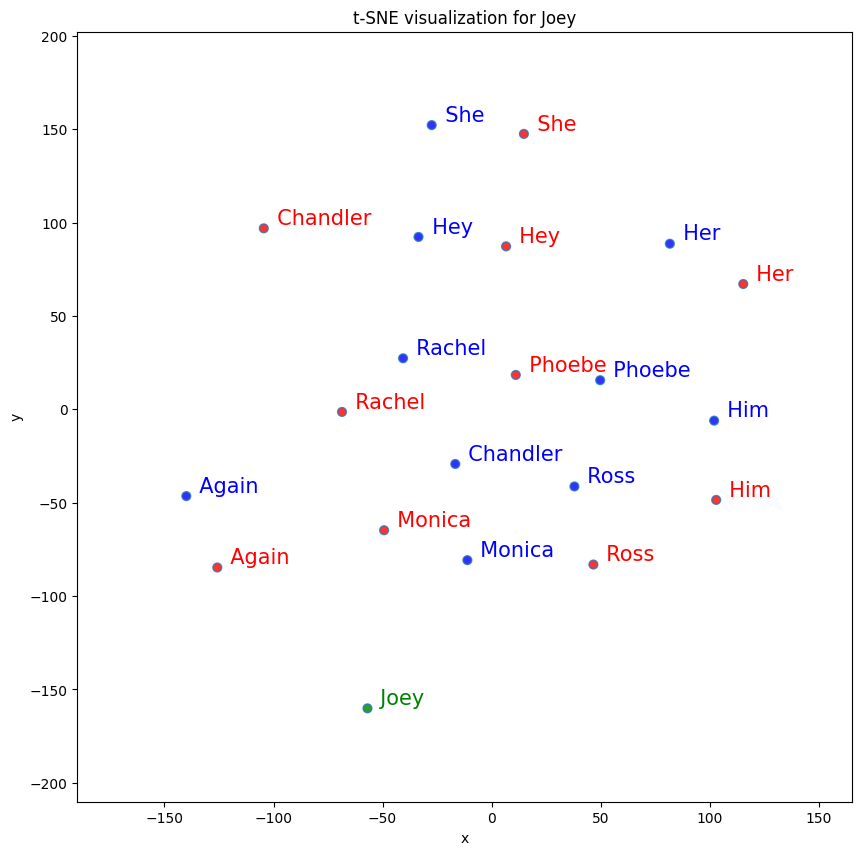

In [35]:
tsneplot(w2v, "joey")

## Task 2: Multi-class Classification (1 + 3 + 2 = 6 points)
In this task, we aim to classify consumer finance complaints into 12 pre-defined classes. Note that this is not a multi-label task, and we assume that each new complaint is assigned to one and only one category. The data comes from https://www.data.gov/ (US government’s open data) and contains complaints that are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whatever comes first.


### Sub Task 1: Data Exploration

Read the data to a pandas dataframe from `complaints.csv` (also located in the `data` folder); this is a rather large file of 206MB. Keep only the `Consumer complaint narrative` (input text) and `product` (labels). Remove the missing values, rename `Consumer complaint narrative` to `Narrative` for ease of use, and add a column encoding the product as an integer. This will represent your labels for classification and the mapping will be used later on. Create two dictionaries: one mapping the ids to products and one mapping products to their ids.

In [135]:
import pandas as pd
%matplotlib inline
df1 = pd.read_csv('data/complaints.csv')
df =  df1[['Product','Consumer complaint narrative']]
df.head()


,Product,Consumer complaint narrative
0,Checking or savings account,NaN
1,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
2,Vehicle loan or lease,NaN
3,Checking or savings account,NaN
4,Checking or savings account,NaN


In [137]:
#rename the column 
df.rename(columns={"Consumer complaint narrative": "narrative"}, inplace=True)

C:\Users\shrey\AppData\Local\Temp\ipykernel_13376\1466441373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Consumer complaint narrative": "narrative"}, inplace=True)


In [138]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df.dropna(inplace=True)
df['product_id'] = le.fit_transform(df['Product'])
### create the dictionary #### 
df.head()


C:\Users\shrey\AppData\Local\Temp\ipykernel_13376\656685156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\shrey\AppData\Local\Temp\ipykernel_13376\656685156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['product_id'] = le.fit_transform(df['Product'])


,Product,narrative,product_id
1,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",5
5,Vehicle loan or lease,I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENT...,12
6,Student loan,My original lender was XXXX XXXX XXXX ; this l...,11
8,Student loan,I was misled by XXXX XXXX and my degree did n...,11
10,Vehicle loan or lease,I purchased a vehicle 3 years ago. As of recen...,12


In [121]:
# df['product_id'] = le.fit_transform(df['Product'])

In [139]:
le.fit(df['Product'])
le_name_mapping1 = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping1) # maps product to ID
le_name_mapping2 = dict(zip(le.transform(le.classes_),le.classes_))
print(le_name_mapping2) # maps product to ID

{'Bank account or service': 0, 'Checking or savings account': 1, 'Consumer Loan': 2, 'Credit card': 3, 'Credit reporting': 4, 'Money transfer, virtual currency, or money service': 5, 'Money transfers': 6, 'Other financial service': 7, 'Payday loan': 8, 'Payday loan, title loan, or personal loan': 9, 'Prepaid card': 10, 'Student loan': 11, 'Vehicle loan or lease': 12, 'Virtual currency': 13}
{0: 'Bank account or service', 1: 'Checking or savings account', 2: 'Consumer Loan', 3: 'Credit card', 4: 'Credit reporting', 5: 'Money transfer, virtual currency, or money service', 6: 'Money transfers', 7: 'Other financial service', 8: 'Payday loan', 9: 'Payday loan, title loan, or personal loan', 10: 'Prepaid card', 11: 'Student loan', 12: 'Vehicle loan or lease', 13: 'Virtual currency'}


In [140]:
df.sort_values('product_id',ascending=False)

,Product,narrative,product_id
500658,Virtual currency,Coinbase account closed without reasonable exp...,13
485397,Virtual currency,Money was going to be transferred from XXXX to...,13
365601,Virtual currency,"Coinbase rep, XXXX has been being an XXXX to m...",13
481443,Virtual currency,I first initiated a support ticket trying to r...,13
124073,Virtual currency,"Hi, on XXXX XXXX, I paid XXXX $ in XXXX to my ...",13
...,...,...,...
434230,Bank account or service,Wells Fargo Bank legal department put my accou...,0
434231,Bank account or service,"As described in Wells Fargo ( WF ) web site, a...",0
434238,Bank account or service,My account became over drawn for around {$200....,0
434239,Bank account or service,I am a senior citizen who has been vulnerable ...,0


In [141]:
df.product_id.value_counts()

4     31588
11    27299
1     27016
3     18838
0     14885
5     11875
12    11334
2      9473
9      8500
8      1746
6      1497
10     1450
7       292
13       16
Name: product_id, dtype: int64

In [142]:
df[df.product_id == 4]

,Product,narrative,product_id
9575,Credit reporting,I have recently submitted a complaint with Equ...,4
9598,Credit reporting,I have written several letters to date regardi...,4
10819,Credit reporting,I contacted the Bankruptcy court asking their ...,4
11138,Credit reporting,I am a victim of identity theft. I have faxed ...,4
11146,Credit reporting,"Equifax, XXXX and XXXX credit reporting agency...",4
...,...,...,...
559352,Credit reporting,I went down to the courthouse and spoke to the...,4
559364,Credit reporting,"I have been a victim if inquiry issue,",4
559365,Credit reporting,I submitted all required information for ident...,4
559366,Credit reporting,I was trying to get my credit reports from all...,4


Look at the class distribution of the products. It is always a good idea to look at the relative number of instances for each class before performing any classification task. Use the `plot` function from the dataframe to show the number of instances in each class in a histogram.

<Figure size 1000x800 with 0 Axes>

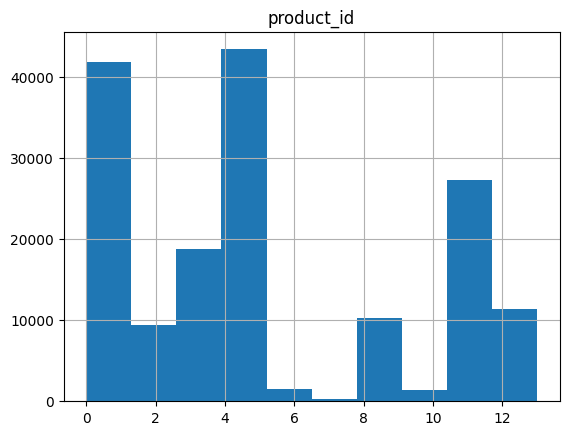

In [144]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
df.hist(column='product_id')
plt.show()

If you have done the exercise correctly you should observe a class imbalance with `credit reporting` having the most complaints. This can result in some difficulties for standard algorithms, making them biased towards the majority class and treating the minority classes as outliers and unimportant. One way to overcome this problem is by using **undersampling** or **oversampling**. However, this is beyond the scope of this assignment.

### Sub Task 2: Text Representation and Training the Classifier 
Before performing any classification we need to split our data into train and test sets. Use `sklearn` to save 20 percent of the data for the test and the rest for training. Make sure to input the index of the data frame to retrieve the indices of the test and train. To ensure reproducibility, use `random_state=42`.


In [149]:
df12 = df.reset_index()
df_train = df12[['index','Product','narrative']]
df_test = df12[['product_id']]
df_train = df.narrative
df_test = df.product_id

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train,indices_test = train_test_split(df_train,df_test, df.index,test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(132647,)
(33162,)
(132647,)
(33162,)


To perform any sort of classification task, we first need to convert our raw text into some vector representation. Let's use the `TfidfVectorizer` from `sklearn` to convert the `narrative` column into TF-IDF vectors. When transforming the text keep the following in mind:
- use the logarithmic form for frequency
- remove accents (ASCII) 
- lowercase all characters 
- remove `English` stop words 
- ignore terms that have a document frequency strictly less than 10
- smooth IDF weights by adding one to document frequencies 
- output row should have unit L2 norm
- set the encoding to `Latin-1`
- extract both uni-grams and bi-grams 
- build a vocabulary that only considers the top 10.000 features
Keep in mind that the vectorizer should be trained **only** on the training data, and the test data should be transformed using the same model.

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(lowercase=True,strip_accents='ascii',stop_words='english',min_df=10,norm='l2',encoding='Latin-1',smooth_idf=True,sublinear_tf=True,ngram_range = (1,2),max_features=10000)
X_train = tfidf.fit_transform(X_train)
X_train.shape # should be (132647, 10000) 

(132647, 10000)

In [153]:
X_test1 = tfidf.transform(X_test)
X_test1.shape

(33162,)

After the data transformation, we attain the features and labels, to train the classifier. In our case, we use **Naive Bayes Classifier**. 
- use `MultinomialNB` from sklearn to classify the data 

In [154]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
clf.fit(X_train,y_train)


MultinomialNB()

In [155]:
y_pred = clf.predict(X_test1)

In [156]:
print(y_test.shape)
print(y_pred.shape)

(33162,)
(33162,)


In [157]:
# examine class distribution
print(y_test.value_counts())

4     6392
1     5420
11    5393
3     3884
0     2958
5     2317
12    2222
2     1913
9     1670
8      373
6      289
10     273
7       56
13       2
Name: product_id, dtype: int64


In [158]:
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.7388577287256498

### Sub Task 3: Model Evaluation  

We evaluate our model using the held-out test data. We are going to look at the confusion matrix to show the performance of the model. 

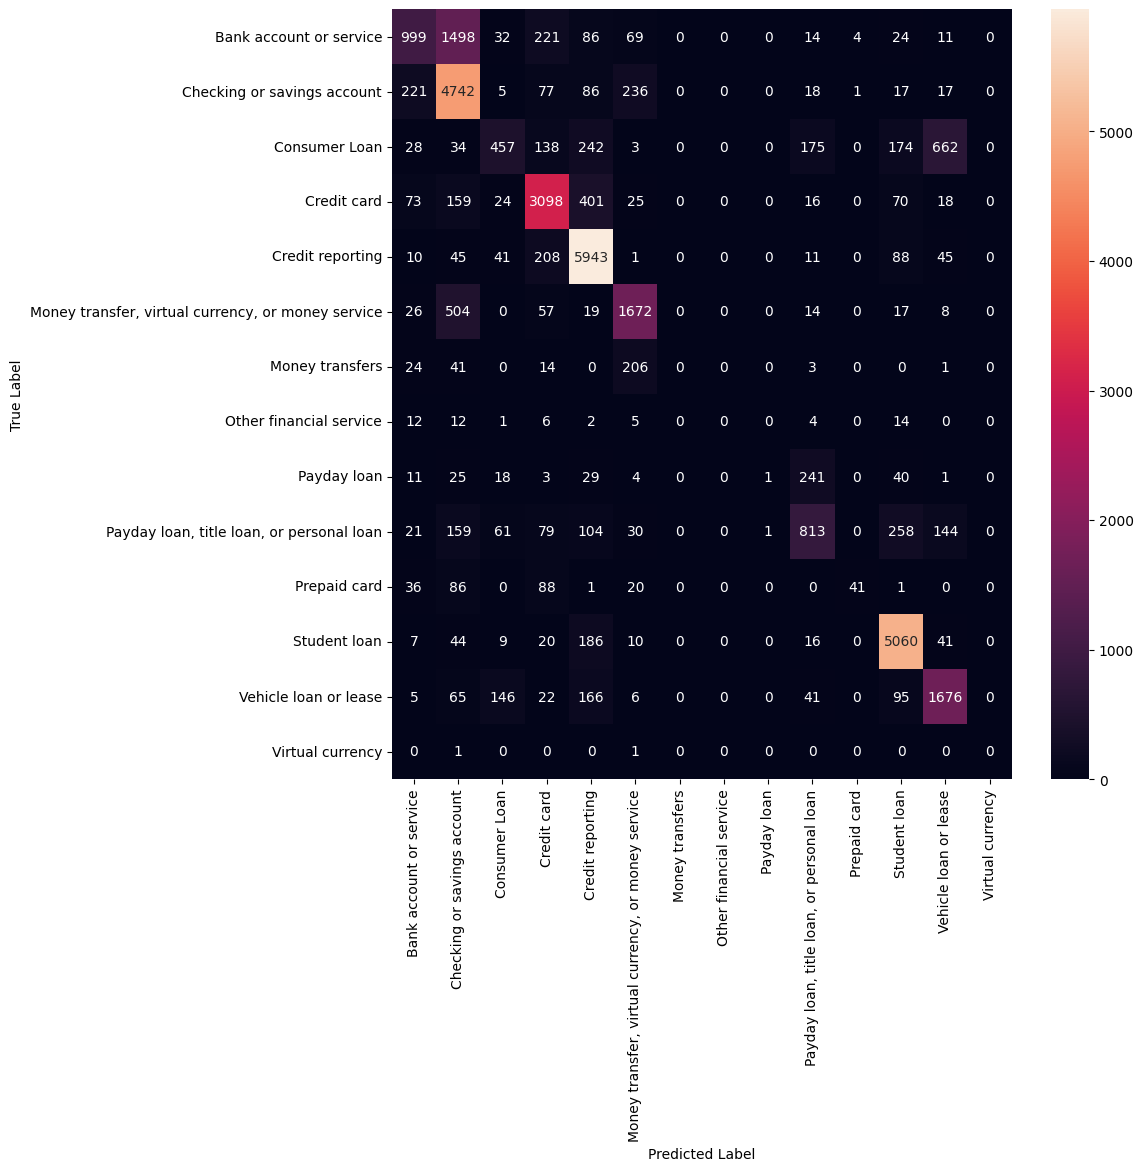

In [159]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = clf.predict(X_test1)

conf = confusion_matrix(y_test, y_pred) ### create the confusion matrix ### 
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels=le_name_mapping1 , ###products names from the dictionary ###,
            yticklabels=le_name_mapping1  ### products names from the dictionary###
            )
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The majority of the predictions end up on the diagonal (predicted label = actual label). The diagonal shows the correct classified classes. However, there are several misclassifications, specifically `Checking or savings account` is often confused with `Bank account or service`. Let's take a look at why this happens. For this, we look at 5 misclassified examples.

In [160]:
actual = 'Bank account or service'
predicted = 'Checking or savings account'
### print only the top 5 
df###choose the ones that have an actual label of Bank account or service and the predicted label of Checking or savings account ###)


,Product,narrative,product_id
1,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",5
5,Vehicle loan or lease,I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENT...,12
6,Student loan,My original lender was XXXX XXXX XXXX ; this l...,11
8,Student loan,I was misled by XXXX XXXX and my degree did n...,11
10,Vehicle loan or lease,I purchased a vehicle 3 years ago. As of recen...,12
...,...,...,...
559376,Bank account or service,I had called Citibank on XXXX/XXXX/XXXX around...,0
559377,Student loan,"I contacted FedLoan Servicing via their "" Cont...",11
559378,Student loan,Over the life of my Student Loans through XXXX...,11
559379,Consumer Loan,I was on automatic payment for my car loan. In...,2


As you can see, some of the misclassified complaints are complaints that are not easy to distinguish. 

## Task 3: Auto-Complete (2 + 5 + 4 = 11 points)
Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]

By the end of this assignment, you will develop a simple prototype of such a system using n-gram language models. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word. 

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language models by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Sub Task 1: Load and Preprocess Data 
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where tweets are separated by `\n`

In [84]:
import math
import random
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])


with open("data/twitter.txt", "r",encoding='utf-8') as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")


First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.) 
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required, although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [86]:
import re

def split_data(data):
  # Split data into sentences
  sentences = re.split(r'\n', data)

  # Remove leading and trailing spaces and drop empty sentences
  sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

  return sentences
sentences = split_data(data)



In [87]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [88]:
tokenized_corpus = [] # list of list of the tokens in a sentence 
##Your Code###   

def tokenize(sentences):
  # Tokenize each sentence into lowercased words
  tokenized_corpus = []
  for sentence in sentences:
    doc = nlp(sentence)
    tokenized_corpus.append([token.text.lower() for token in doc])
  return tokenized_corpus

words = tokenize(sentences)


In [89]:
from sklearn.model_selection import train_test_split
from random import Random
Random(4).shuffle(words)

split_index = int(len(words) * 0.8)

# Split the tokenized corpus into a training set and a test set
train = words[:split_index]
test = words[split_index:]

In [90]:
from collections import Counter
flatten_corpus = [word for sentence in train for word in sentence] ### Flatten the train corpus ### 

word_counts =  Counter(flatten_corpus)### count the number of each token ### 
vocab = []
vocab = [word for word, count in word_counts.items() if count >= 2]

### keep only the ones with frequency bigger than 2 ### 
print(len(vocab)) ### should be 14861 ### 
train_replaced = []
test_replaced = []
for sentence in train:
    ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest #### 
    train_replaced.append([word if word in vocab else '<unk>' for word in sentence])
for sentence in test:
    ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest #### 
    test_replaced.append([word if word in vocab else '<unk>' for word in sentence])


14861


### Sub Task 2: N-gram Based Language Model: 
In this section, you will develop the n-grams language model. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word 't' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will: 
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below. 

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n-gram counts (called n_gram in the code).

In [91]:
from collections import defaultdict


def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n 
    
    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram
    
    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus: 
        ### add start and end token ###
        sentence = [start_token] + sentence + [end_token]
        # convert list to tuple so it can be used a the key in the dictionary 
        sentence = tuple(sentence)
        
        for i in range(len(sentence) - n + 1):
            n_gram = tuple(sentence[i:i+n])
            n_grams[n_gram] += 1
        
        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count 
    return n_grams

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [92]:

def probability(word, prev_n_gram, 
                         n_gram_cnts, n_plus1_gram_cnts, vocab_size):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary
    
    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)
    
    prev_n_gram_cnt = n_gram_cnts[prev_n_gram] # get the previous n-gram count from the dictionary 
    denominator =  prev_n_gram_cnt + k*vocab_size# denominator with the previous n-gram count and k-smoothing
    n_plus1_gram =  prev_n_gram + (word,)# add the current word to the n-gram 
    n_plus1_gram_cnt =  n_plus1_gram_cnts.get(n_plus1_gram, 0)# get the current n-gram count using the dictionary
    numerator = n_plus1_gram_cnt + k#calculate the numerator with k-smoothing
    prob = numerator / denominator
    
    return prob


Let's use the functions we have defined to calculate probabilities for all possible words.


In [93]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram 
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    
    Returns: A dictionary mapping from next words to the probability.
    """
    k =1.0
    prev_n_gram = tuple(prev_n_gram)
    
    vocab =  vocab + ['<e>', '<unk>']# add <e> <unk> to the vocabulary
    
    vocabulary_size = len(vocab)#compute the size 
    denominator = sum(n_gram_cnts.values()) + k*vocabulary_size 
    
    probabilities = {}
    for word in vocab:
        
        n_plus1_gram = prev_n_gram + (word,) # add the current word to the n-gram 
        n_plus1_gram_cnt = plus_current_gram_cnts.get(n_plus1_gram,0) # get the current n-gram count using the dictionary
        numerator = n_plus1_gram_cnt + k #calculate the numerator with k-smoothing
        prob = numerator / denominator
        probabilities[word] = prob
    return probabilities


In [94]:
 # Predict the probability of the all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)


The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'stars': 0.021739130434782608,
 'tonight': 0.021739130434782608,
 'are': 0.021739130434782608,
 'is': 0.021739130434782608,
 'shining': 0.021739130434782608,
 'plant': 0.021739130434782608,
 'bright': 0.021739130434782608,
 'plants': 0.021739130434782608,
 'a': 0.021739130434782608,
 'the': 0.021739130434782608,
 'moon': 0.08695652173913043,
 'and': 0.021739130434782608,
 'mars': 0.021739130434782608,
 'shinnig': 0.021739130434782608,
 '<e>': 0.021739130434782608,
 '<unk>': 0.021739130434782608}

### Sub Task 3: Evaluation 

In this part we use the perplexity score to evaluate your model on the test set.
The perplexity score of the test set on an n-gram model is defined as follows: 

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.

Notice that we have already computed this probability. 

The higher the probabilities are, the lower the perplexity will be. 

In [95]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant
    Returns: Perplexity score for a single sentence 
    """
    
    n =  len(list(n_gram_cnts.keys())[0]) - 1 # get the number 'n' in  n-gram  from n_gram_cnts  
    
    sentence = ["<s>"] + sentence + ["<e>"] # prepend <s> and append <e>
    sentence = tuple(sentence)
    N = len(sentence)# length of sentence 
    
   
    product_pi = 1.0 
    
    ### Compute the product of probabilites ###
    
    for t in range(n, N): 
        n_gram = sentence[t-n:t]# get the n-gram before the predicted word (n-gram before t )
        word = sentence[t] # get the word to be predicted (position t)
        prob = probability(word, n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size)
        product_pi *= prob # Update the product of the probabilities
    
    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity


Use the function to find the perplexity of a bi-gram model on the first instance of training and test set.

In [96]:
bigram_counts = n_grams_counts(train_replaced, 2)### your code ###
trigram_counts =  n_grams_counts(train_replaced, 3)### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the preprexity for the train sample should be much lower


Perplexity for first train sample: 0.0003
Perplexity for test sample: 0.0001


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [97]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n 
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word
        
    Returns: (most likely next word,  probability) 
    """    
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts     
    previous_n_gram = up_to_here[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    
     # Estimate the probabilities for each word in the vocabulary
    probabs = {}
    for word in vocab:
        
        probabs[word] = probability(word, previous_n_gram, n_gram_cnts, plus_current_gram_cnts, len(vocab))

    
    probabs = sorted(probabs.items(), key=lambda x: x[1], reverse=True)
    if start_with is not None:
        probabs = [x for x in probabs if x[0].startswith(start_with)]
    return probabs[0]
    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character 


Test your model based on the bi-gram model created on the training corpus.

In [98]:
previous_tokens = ['i', 'like']
start_with = 'g'
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


('going', 0.00013326226012793177)

In [99]:
previous_tokens = ['i', 'like', 'to']
start_with = None
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


('see', 0.0006018054162487463)

In [100]:
previous_tokens = ["hello", "my", "name", "is"]
start_with = None
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


('riley', 0.00020155872077398548)

In [101]:
previous_tokens = ["hello", "my", "name", "is"]
start_with = 'sa'
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


('safe', 6.718624025799516e-05)

Decaying learning has the advantage that at the beginning of training where the model weights are usually
chosen at random, the algorithm can fastly converge towards a minimum. After more and more steps, it can be
assumed that the solution is near such a minimum, and only smaller steps are taken, such that the algorithm can 
now "fine-tune" model parameters, instead of altering weights massively, potentially stepping over the optimal
the solution again and again.

## Task 4: Model Evaluation & Comparison (1 + 2 + 2 + 2 = 7 points)

In this task we want to evaluate and compare the performance of three different imaginary spam mail classifiers. The file `spam_ham_dataset_predictions.csv` consists of a dataset of e-mails with the labels `ham (0)` and `spam (1)` which was taken over from [Kaggle](https://www.kaggle.com/code/syamkakarla/spam-mail-classifier/data). Additionally, predictions from three different models (A, B and C) were added to the dataset.

### Subtask 1: Class Distribution

We start by loading the data and looking at it first. Since we want to evaluate the performance of the given classifiers, one of the important aspects to know is how the classes are distributed within the dataset. Therefore, we extract the true distribution of classes from the gold labels as well as the predicted distributions of classes from the predicted labels of the models.

In [102]:
df = pd.read_csv("data/spam_ham_dataset_predictions.csv", index_col=0)
df

,label,text,label_num,prediction_model_A,prediction_model_B,prediction_model_C
3063,ham,"Subject: tenaska iv 12 / 00 , 2 / 01 and 3 / 0...",0,1,1,0
1661,ham,Subject: revised : eastrans nomination change ...,0,1,1,0
2816,ham,Subject: neon lesson # 5\r\nhere is the lesson...,0,1,1,0
1507,ham,Subject: cornhusker\r\ni have entered deals in...,0,1,1,0
955,ham,Subject: prior month misnomination\r\ndaren - ...,0,1,1,0
...,...,...,...,...,...,...
503,ham,Subject: 23 rd noms\r\n- - - - - - - - - - - -...,0,0,0,0
1764,ham,Subject: tenaska iv outage update\r\nfyi .\r\n...,0,0,0,0
2941,ham,Subject: me again\r\ndid you survive bid week ...,0,0,0,0
1958,ham,Subject: 6 / 4 / 99 and 6 / 9 / 99 ( 98 - 0439...,0,0,0,0


In [103]:
class_distribution = df[["label_num", "prediction_model_A", "prediction_model_B", "prediction_model_C"]]### your code ###

# renaming the rows for a nicer table and plot
class_distribution = class_distribution.rename(columns={
    "label_num": "Gold Labels",
    "prediction_model_A": "Model A",
    "prediction_model_B": "Model B",
    "prediction_model_C": "Model C"
})

# display the class distribution table
class_distribution


,Gold Labels,Model A,Model B,Model C
3063,0,1,1,0
1661,0,1,1,0
2816,0,1,1,0
1507,0,1,1,0
955,0,1,1,0
...,...,...,...,...
503,0,0,0,0
1764,0,0,0,0
2941,0,0,0,0
1958,0,0,0,0


[('Gold Labels', 0), ('Gold Labels', 1), ('Model A', 0), ('Model A', 1), ('Model B', 0), ('Model B', 1), ('Model C', 0)]
Gold Labels  0    3672.0
             1     240.0
Model A      0    3681.0
             1     231.0
Model B      0    3809.0
             1     103.0
Model C      0    3912.0
dtype: float64


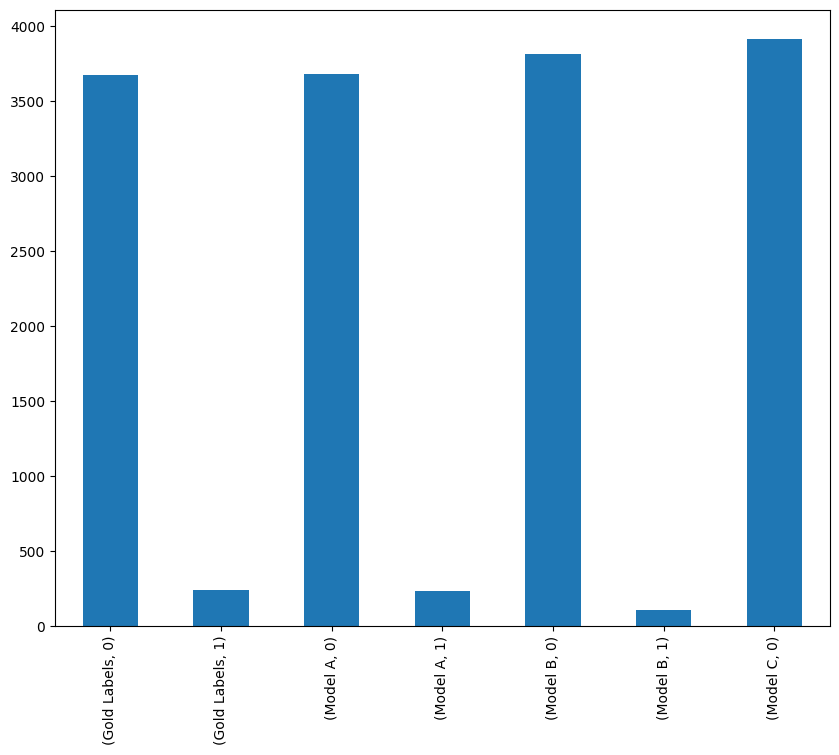

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
count = class_distribution.apply(lambda x: x.value_counts()).T.stack()
#count.iloc[1,0]
print(count.index.tolist())
print(count[:])
count.plot.bar()
#    count[""]
plt.show()

You should see that the distribution of classes in the dataset is very unbalanced. There are far more "ham" mails than spam mails in the dataset. Model A comes closest to the real distribution, while Model B predicts even fewer spam mails than actually exist. An extreme case is Model C, which classifies all mails as unproblematic "ham" mails and assumes no spam mails in the data set.

Obviously, based on the predicted distributions, we cannot yet estimate how many labels were actually predicted correctly. Therefore, we calculate this in the next step.

### Sub Task 2: Accuracy

To see which model made the most correct predictions, we want to calculate the accuracy in the next step. In general, the metric of the accuracy is defined as follows:
$$
\text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}}\\
$$.

In the case of binary classification, the accuracy can be calculated as follows:
$$
\begin{align*}
\text{Accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}\\
\text{Accuracy} &= \frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{false positives} + \text{true negatives} + \text{false negatives}}\\
\end{align*}
$$

First, define methods that return TP, TN, FP and FN for a given model from the DataFrame.

In [105]:
def true_positives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    df["New"] = df.apply(lambda x: 1 if x[prediction_column]==x[gold_label_column] and\
         x[prediction_column] > 0 else 0, axis = 1)
    #print(df["New"].tolist())
    return df["New"].sum()### your code ###

def true_negatives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    df["New"] = df.apply(lambda x: 1 if x[prediction_column]==x[gold_label_column] and\
    x[prediction_column] == 0 else 0, axis = 1)
    #print(df["New"].tolist())
    return df["New"].sum()

def false_positives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    df["New"] = df.apply(lambda x: 1 if x[prediction_column]>x[gold_label_column] else 0, axis = 1)
    #print(df["New"].tolist())
    return df["New"].sum()

def false_negatives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    df["New"] = df.apply(lambda x: 1 if x[prediction_column]<x[gold_label_column] else 0, axis = 1)
    #print(df["New"].tolist())
    return df["New"].sum()


In [106]:
# testtrue_positives(class_distribution, "Model A", "Gold Labels")
print(true_positives(class_distribution, "Model A", "Gold Labels"))
print(true_negatives(class_distribution, "Model A", "Gold Labels"))
print(false_positives(class_distribution, "Model A", "Gold Labels"))
print(false_negatives(class_distribution, "Model A", "Gold Labels"))

48
3489
183
192


Now define the method for calculating the accuracy using parameters for the values for TP, TN, FP and FN.

In [107]:
def accuracy(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num"):
    t_p = true_positives(df, prediction_column, gold_label_column)
    t_n = true_negatives(df, prediction_column, gold_label_column)
    f_p = false_positives(df, prediction_column, gold_label_column)
    f_n = false_negatives(df, prediction_column, gold_label_column)
    accuracy_val = (t_p+t_n)/(t_p+t_n+f_p+f_n)
    return accuracy_val

In [108]:
# test
accuracy(class_distribution, "Model A", "Gold Labels")

0.9041411042944786

After having defined the methods, we can now calculate the accuracy for each model. To be able to reuse the calculated values and additionally depict them in a DataFrame, we store the results in a dictionary. 

In [109]:
# dictionary for storing all results
evaluation_results = {}

for model in ["A", "B", "C"]:
    # column with the predicted labels from the model in the df
    prediction_column = f"prediction_model_{model}"
    str_temp = "Model "+model
    # save TP, FP, TN and FN for this model
    evaluation_results[model] = {
        "TP":int(true_positives(class_distribution, str_temp, "Gold Labels")),
        "FP":false_positives(class_distribution, str_temp, "Gold Labels"),
        "TN":true_negatives(class_distribution, str_temp, "Gold Labels"),
        "FN":false_negatives(class_distribution, str_temp, "Gold Labels"),
        ### your code ###
    }

    # save accuracy for this model
    evaluation_results[model]["accuracy"] = \
        accuracy(class_distribution,str_temp , "Gold Labels")

# create a temporary DataFrame for displaying the results in a table
pd.DataFrame(evaluation_results)


,A,B,C
TP,48.000000,30.000000,0.00000
FP,183.000000,73.000000,0.00000
TN,3489.000000,3599.000000,3672.00000
FN,192.000000,210.000000,240.00000
accuracy,0.904141,0.927658,0.93865


You should see that all models have a very high accuracy. This can be explained by the uneven distribution of the data, which is roughly reflected by all models.

We also see that Model C has the highest accuracy and is therefore the best classifier according to this metric. However, since Model C does not recognize spam mails at all, but classifies all mails as "ham", this model will not add any value in practice. The use of the model would have no effect.

Therefore, in the next step we want to look at other metrics with which we can compare the classifiers.

### Sub Task 3: Precision, Recall, F-measure

Two very commonly used metrics for evaluating classifiers are precision and recall. 

Precision measures the percentage of the items that the classifier detected as positive that are actually positive according to the gold labels. Precision is defined as follows:
$$
\text{Precision (\textit{P})} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

Recall measures the percentage of positive items that the classifier was able to detect as positive. Recall is defined as follows:
$$
\text{Recall (\textit{R})} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$


First we will define methods to calculate precision and recall based on the required parameters.

In [110]:
def precision(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num"):
    tp = true_positives(df, prediction_column, gold_label_column)
    fp = false_positives(df, prediction_column, gold_label_column)
    return tp/(tp+fp)

In [111]:
def recall(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num"):
    tp = true_positives(df, prediction_column, gold_label_column)
    fn = false_negatives(df, prediction_column, gold_label_column)
    return tp/(tp+fn)

Now we can calculate precision and recall for the classifiers to see which classifier performs better overall.

*Note*: Since we know that Model C does not generate true positives, both recall and precision will be 0. Besides, we already determined that the model is unsuitable for application. Therefore, we can exclude the model from the following calculations.

In [112]:
# exclude Model C from the following calculations
evaluation_results.pop("C", None)

for model in evaluation_results:
    # save precision and recall for this model
    str_temp = "Model "+model
    evaluation_results[model]["precision"] =\
         precision(class_distribution, str_temp , "Gold Labels")
    evaluation_results[model]["recall"] = \
        recall(class_distribution, str_temp, "Gold Labels")

pd.DataFrame(evaluation_results)


,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000


The calculations should show that Model B has a significantly higher precision than Model A. However, Model A has a higher recall. Thus, we cannot easily decide which model is better. Therefore, we want to combine the two metrics in order to be able to compare the classifiers on the basis of a single value.

One frequently used combination of precision and recall is the F-score. The F-Score is defined as follows:
$$
F_\beta = \frac{(\beta^2 + 1) P R}{\beta^2 P + R}
$$
The $\beta$ parameter in the formula can be used to weight the importance between precision and recall.

The most commonly used value for $\beta$ is $1$. The resulting metric is called $F_1$ score.
$$
F_1 = \frac{2 P R}{P + R}
$$

Let us define a method to calculate the F-score based on the required parameters at first.

In [113]:
def f_beta(df: pd.DataFrame,  beta:float, prediction_column: str, gold_label_column: str = "label_num"):
    P = precision(df, prediction_column, gold_label_column)
    R = recall(df, prediction_column, gold_label_column)
    val_temp = (beta**2+1)*P*R/(beta**2*P+R)
    return val_temp

Now we want to calculate the $F_1$ score for the classifiers to see which one performs better overall. 

In [114]:
for model in evaluation_results:
    # save the F_1 score for this model
    str_temp = "Model "+model
    evaluation_results[model]["F_1"] = f_beta(class_distribution,1, str_temp , "Gold Labels")

pd.DataFrame(evaluation_results)


,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000
F_1,0.203822,0.174927


After correct calculation you should see that the $F_1$ score of Model A is higher than that of Model B. Accordingly, Model A is the better classifier if we want to weight precision and recall equally.

### Sub Task 4: Adapting the metric to the use case

Let's not stop at that point. Is Model A really better for spam detection than Model B?

Consider why Model B might be better than Model A for the spam detection use case in practice. Consider how the metric could be easily adapted for the purpose of spam detection. 

Calculate an adjusted metric for the models and briefly explain the adjustment and the result.

In [115]:
"""I find it interesting to explore more options for classifier evaluation. 
I tested the AUC framework on the two models and find A still superior, as 
AUC generally places recall and precision on the same importance level.
"""
# with inspiration from https://zhuanlan.zhihu.com/p/110015537
def AUC(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num"):
    label = df[gold_label_column].tolist()
    pre = df[prediction_column].tolist()
    positive = [i for i in range(len(label)) if label[i] == 1]
    negative = [i for i in range(len(label)) if label[i] == 0]
    num_temp = len(positive)*len(negative)
    AUC = 0 # initialize
    for pred1 in positive:
        for pred2 in negative:
            if pre[pred1]>pre[pred2]:
                AUC += 1
            elif pre[pred1] == pre[pred2]:
                AUC +=0.5
    return AUC / num_temp
    

In [116]:
for model in evaluation_results:
    str_temp = "Model "+model
    evaluation_results[model]["AUC"] = AUC(class_distribution, str_temp , "Gold Labels")
pd.DataFrame(evaluation_results)


,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000
F_1,0.203822,0.174927
AUC,0.575082,0.552560


In [117]:
"""give beta less than one and calculate the F beta metric."""
for model in evaluation_results:
    str_temp = "Model "+model
    evaluation_results[model]["F_beta"] = f_beta(class_distribution,0.5, str_temp , "Gold Labels")
pd.DataFrame(evaluation_results)


,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000
F_1,0.203822,0.174927
AUC,0.575082,0.552560
F_beta,0.206186,0.230061


**Your brief explanation:** 


For spam detection, the general rule should be that we would rather have more false negatives(normal emails that are classified as spams) than false positives(spams that are let in by the algorithm). Thus the beta value of F beta metric should not be one, since the weight we place on precision and recall should be different, with precision being of higher importance.

Model B, while is with less recall, is of clearly higher precision. Placing precision on the first place, we calculate the F beta score with beta less than one, and not to our surprise we see B is superior under this metric.